In [1]:
import os
import sys
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import joblib

from sklearn.metrics import root_mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

# Ensure you have your custom imports available
sys.path.append(os.path.abspath("../features"))
from data_loading import create_features_and_targets
from huggingface_hub import PyTorchModelHubMixin

sys.path.append(os.path.abspath("../utils"))

from utils import (
    evaluate_predictions_3_days,
    plot_predictions_vs_true,
    plot_losses,
)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [2]:
particle = "NO2"
data_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "data/processed/combined_data.csv")
data = pd.read_csv(data_path)
X_train, y_train, X_test, y_test, X_val, y_val = create_features_and_targets(data, particle)

Number of rows with missing values dropped: 1011


In [3]:
print(type(X_test))

<class 'pandas.core.frame.DataFrame'>


In [3]:
class AirPollutionDataset(Dataset):
    def __init__(self, X: pd.DataFrame, y: pd.Series) -> None:
        """
        Initialize the dataset.

        Args:
            X (pd.DataFrame): Feature data.
            y (pd.Series): Target data.
        """
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self) -> int:
        """Return the number of samples in the dataset."""
        return len(self.X)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """Retrieve a sample from the dataset.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the feature and target tensors.
        """
        return self.X[idx], self.y[idx]


class AirPollutionNet(nn.Module, PyTorchModelHubMixin):
    def __init__(self, input_size: int, layers: list[int], dropout_rate: float) -> None:
        """
        Initialize the neural network model.

        Args:
            input_size (int): Number of input features.
            layers (list[int]): List of integers representing the number of units in each layer.
            dropout_rate (float): Dropout rate for regularization.
        """
        super(AirPollutionNet, self).__init__()
        self.layers_list = nn.ModuleList()
        in_features = input_size

        for units in layers:
            self.layers_list.append(nn.Linear(in_features, units))
            self.layers_list.append(nn.ReLU())
            self.layers_list.append(nn.Dropout(p=dropout_rate))
            in_features = units

        self.output = nn.Linear(in_features, 3)  # Output size is 3 for next 3 days

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Perform a forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after forward pass.
        """
        for layer in self.layers_list:
            x = layer(x)
        x = self.output(x)
        return x

In [4]:
train_dataset = AirPollutionDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=1)

test_dataset = AirPollutionDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=1)

val_dataset = AirPollutionDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=1)

In [5]:
input_size = X_train.shape[1]
model = AirPollutionNet(input_size)

In [6]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-05)

In [7]:
num_epochs = 1000
patience = 20 # Early stopping patience

# Early stopping variables
best_loss = float("inf")
stopping_counter = 0
total_train_loss = []
total_val_loss = []
# Training loop
for epoch in range(num_epochs):
    train_losses = []
    for inputs, targets in train_dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = torch.sqrt(criterion(outputs, targets))

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    # Print loss every 10 epochs
    if (epoch + 1) % 1 == 0:
        val_losses = []
        for inputs, targets in val_dataloader:
            with torch.no_grad():
                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = torch.sqrt(criterion(outputs, targets))

                val_losses.append(loss.item())

        total_train_loss.append(np.mean(train_losses))
        total_val_loss.append(np.mean(val_losses))
        # print(
        #     f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {np.mean(train_losses):.4f}, Val Loss: {np.mean(val_losses):.4f}"
        # )

    # Early stopping logic
    if loss.item() < best_loss:
        best_loss = loss.item()
        stopping_counter = 0
        best_model = model
        best_epoch = epoch

    else:
        stopping_counter += 1
        if stopping_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

Early stopping at epoch 30


In [8]:
print(best_epoch)
print(best_loss)

9
0.14017395675182343


In [9]:
# Make predictions

with torch.no_grad():
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    preds = best_model(X_test_tensor).numpy()



7.793737130090264
0.35585292675363434


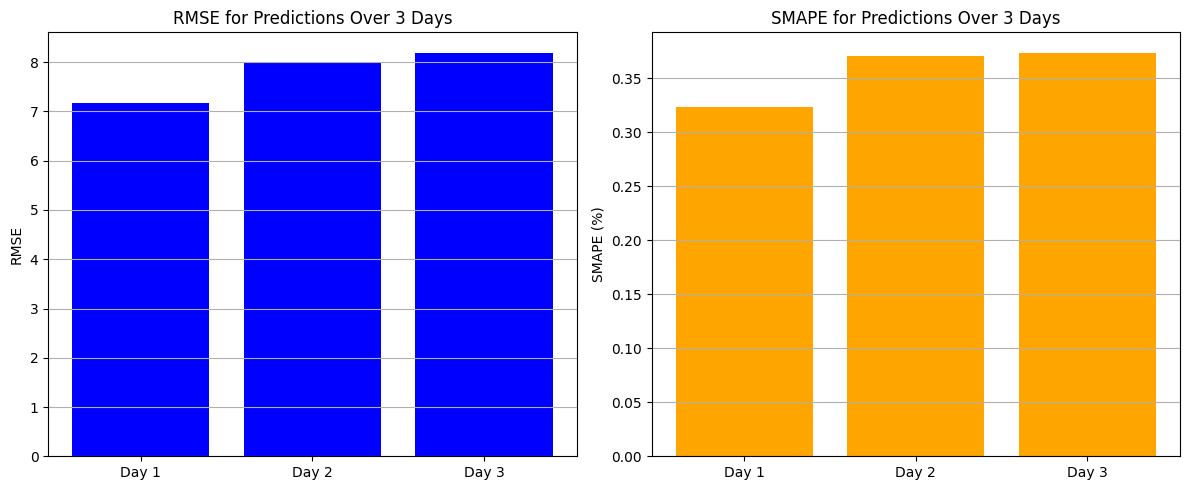

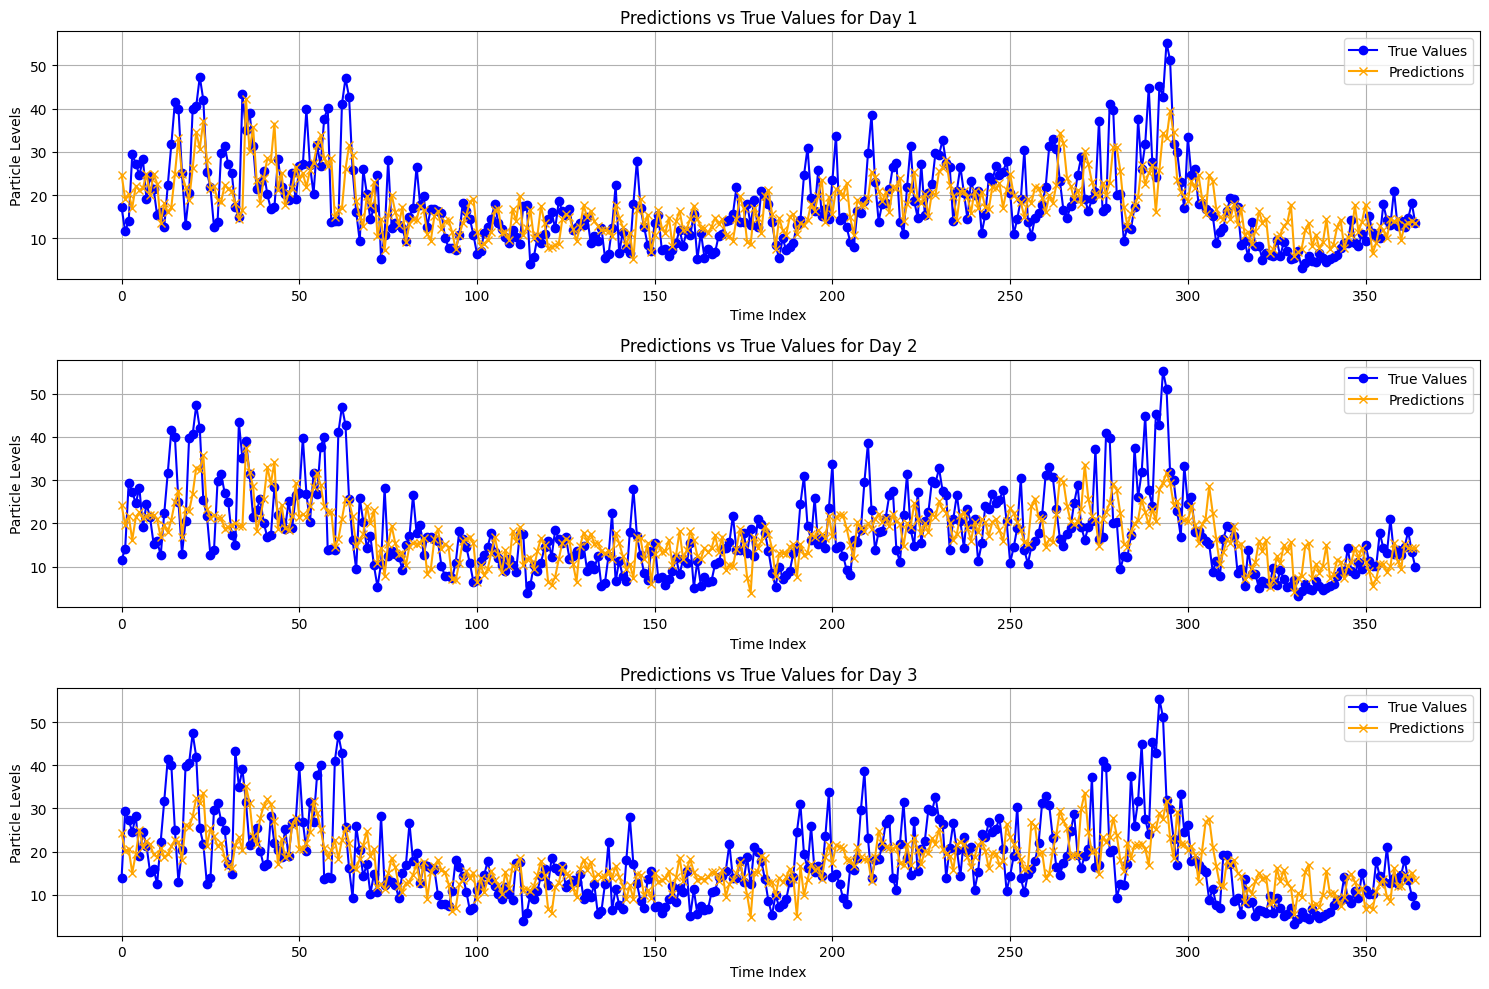

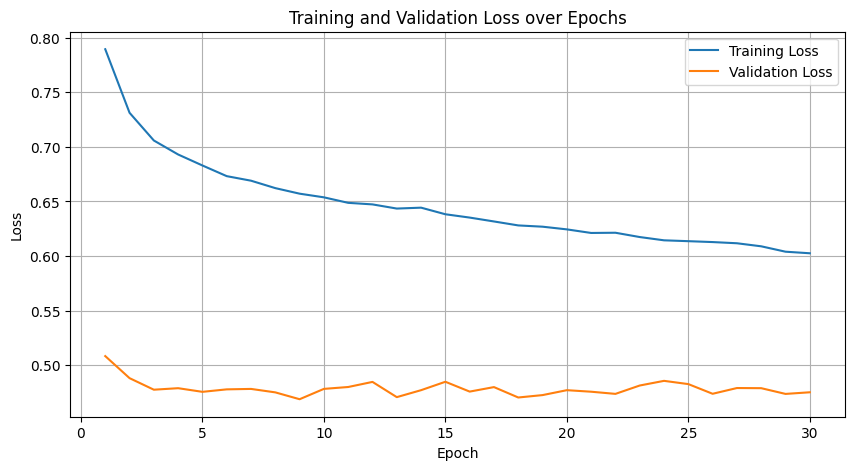

In [10]:
loaded_scaler = joblib.load(f"target_scaler_{particle}.joblib")
preds = loaded_scaler.inverse_transform(preds)
y_test = loaded_scaler.inverse_transform(y_test)
rmse_values_3day, mape_values_3day, fig_3_days = evaluate_predictions_3_days(
    preds, y_test
)
true_vs_pred_plot = plot_predictions_vs_true(preds, y_test)
losses_plot = plot_losses(total_train_loss, total_val_loss, interval=1)

rmse = root_mean_squared_error(y_test, preds)
mape = mean_absolute_percentage_error(preds, y_test, symmetric=True)
print(rmse)
print(mape)

In [11]:
from dotenv import load_dotenv

load_dotenv()


model.push_to_hub(f"akseljoonas/Utrecht_pollution_forecasting_{particle}", token=os.getenv('HF_WRITE'))

model.safetensors: 100%|██████████| 52.6k/52.6k [00:01<00:00, 52.5kB/s]


CommitInfo(commit_url='https://huggingface.co/akseljoonas/Utrecht_pollution_forecasting_NO2/commit/e0cb9bfc87109ab5cbfc81d8cb3a03af1b88e69f', commit_message='Push model using huggingface_hub.', commit_description='', oid='e0cb9bfc87109ab5cbfc81d8cb3a03af1b88e69f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/akseljoonas/Utrecht_pollution_forecasting_NO2', endpoint='https://huggingface.co', repo_type='model', repo_id='akseljoonas/Utrecht_pollution_forecasting_NO2'), pr_revision=None, pr_num=None)